In [196]:
import numpy as np
import pandas as pd
from plotnine import *
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

In [197]:
df = pd.read_csv("covtype.csv", sep=',')

c:\Users\aujo8\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 251'. Pick better value with 'binwidth'.


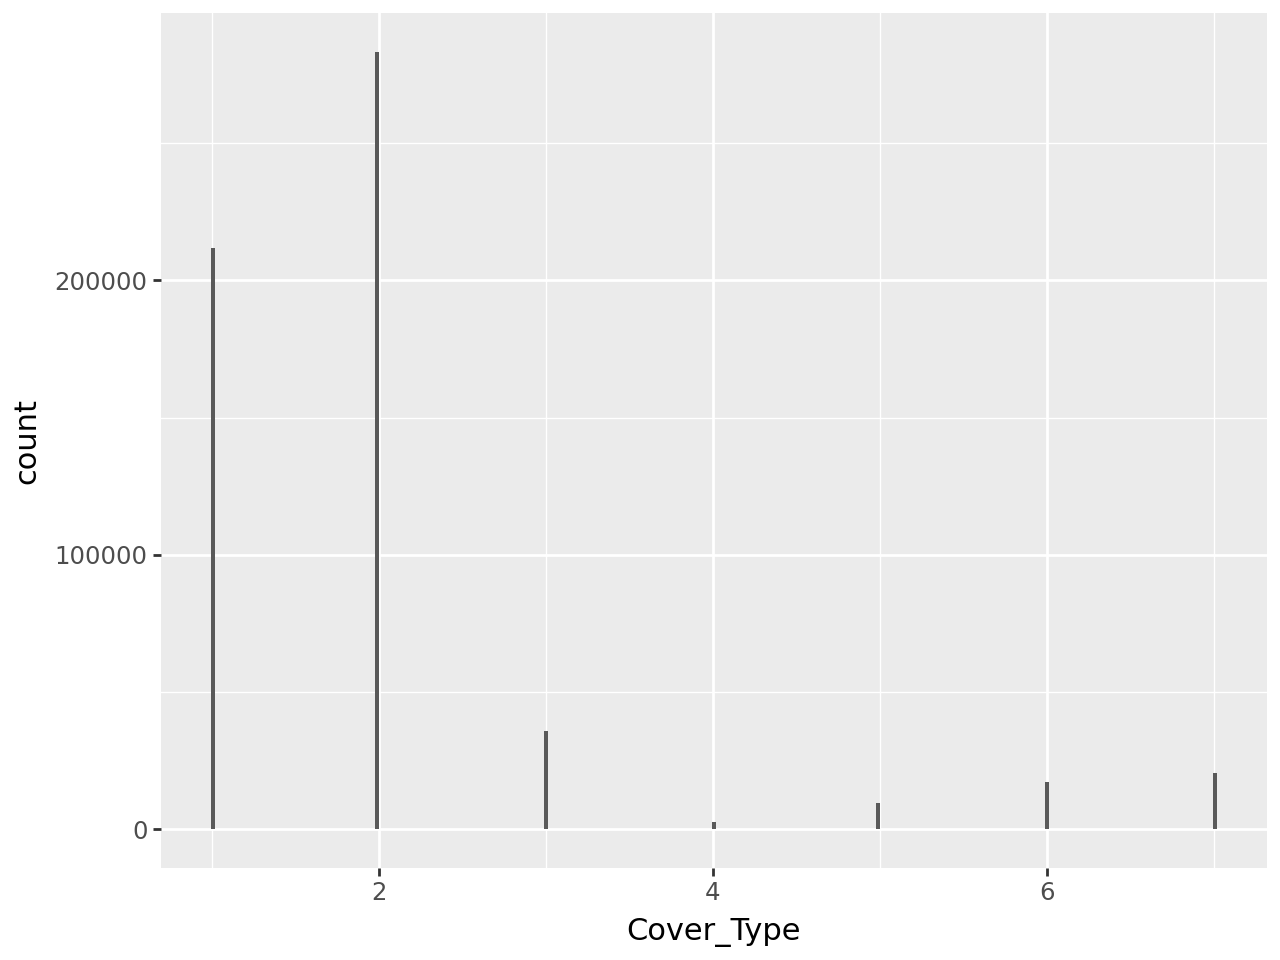

In [198]:
ggplot(df, aes(x="Cover_Type")) +\
    geom_histogram()

## Task 3

In [199]:
def standardize(data):
    m = np.mean(data, axis=0)
    s = np.std(data, axis=0)
    strd_data = (data - m)/s
    return strd_data

## Task 5

In [200]:
train, testval = train_test_split(df, test_size=0.2, random_state=1995)
test, val = train_test_split(testval, test_size=0.5, random_state=1995)

In [ ]:
# standardizing the non-categorical features (the first ten features)
# also seperating the data into targets y and input features X
X_train = pd.concat([standardize(train.iloc[:, 0:10]), train.iloc[:, 10:-1]], axis=1)
y_train = train["Cover_Type"]
# y_train = pd.get_dummies(train["Cover_Type"], dtype=int)

X_test = pd.concat([standardize(test.iloc[:, 0:10]), test.iloc[:, 10:-1]], axis=1)
y_test = test["Cover_Type"]
# y_test = pd.get_dummies(test["Cover_Type"], dtype=int)

X_val = pd.concat([standardize(val.iloc[:, 0:10]), val.iloc[:, 10:-1]], axis=1)
y_val = val["Cover_Type"]
# y_val = pd.get_dummies(val["Cover_Type"], dtype=int)

## Task 6

In [201]:
import os
import torch
from torch.utils.data import DataLoader
from torch import nn

# if possible, running on GPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [202]:
# transforming our data into tensors
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()

X_test_tensor = torch.tensor(X_test.values).float() 
y_test_tensor = torch.tensor(y_test.values).float()

X_val_tensor = torch.tensor(X_val.values).float()
y_val_tensor = torch.tensor(y_val.values).float()

In [203]:
# creating torch datasets in preparation for mini batches
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

# the dataloaders for the mini batches
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

In [204]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 60),
            nn.ReLU(),
            nn.Linear(60, 70),
            nn.ReLU(),
            nn.Linear(70, 60),
            nn.ReLU(),
            nn.Linear(60, 7)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [205]:
# instantiating the model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=54, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=70, bias=True)
    (3): ReLU()
    (4): Linear(in_features=70, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=7, bias=True)
  )
)


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [210]:
learning_rate = 1e-3
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dl, model, loss_fn, optimizer)
    # test_loop(val_dl, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.094826  [   64/464809]
loss: 0.939991  [ 6464/464809]
loss: 1.034701  [12864/464809]
loss: 1.078665  [19264/464809]
loss: 0.984511  [25664/464809]
loss: 0.969837  [32064/464809]
loss: 1.099041  [38464/464809]
loss: 0.984653  [44864/464809]
loss: 1.000488  [51264/464809]
loss: 1.045063  [57664/464809]
loss: 1.069505  [64064/464809]
loss: 1.105978  [70464/464809]
loss: 0.820098  [76864/464809]
loss: 1.187394  [83264/464809]
loss: 1.021109  [89664/464809]
loss: 0.893741  [96064/464809]
loss: 0.891846  [102464/464809]
loss: 0.924527  [108864/464809]
loss: 0.935126  [115264/464809]
loss: 0.840895  [121664/464809]
loss: 1.020008  [128064/464809]
loss: 0.906472  [134464/464809]
loss: 1.112053  [140864/464809]
loss: 0.882141  [147264/464809]
loss: 0.931620  [153664/464809]
loss: 0.872925  [160064/464809]
loss: 0.874560  [166464/464809]
loss: 0.892118  [172864/464809]
loss: 0.857107  [179264/464809]
loss: 1.101958  [185664/464809]
loss: 1.073103  

KeyboardInterrupt: 